In [ ]:
import sys
sys.path.append("/n/home12/binxuwang/Github/mini_edm")
sys.path.append("/n/home12/binxuwang/Github/DiffusionMemorization")
from train_edm import edm_sampler, EDM, create_model
from core.edm_utils import get_default_config, create_edm

In [ ]:
from core.analytical_score_lib import mean_isotropic_score, Gaussian_score, delta_GMM_score
from core.analytical_score_lib import explained_var_vec
from core.analytical_score_lib import sample_Xt_batch, sample_Xt_batch
from core.gaussian_mixture_lib import gaussian_mixture_score_batch_sigma_torch, \
    gaussian_mixture_lowrank_score_batch_sigma_torch, compute_cluster

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from os.path import join
from torchvision.utils import make_grid

## MNIST

In [1]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms

transform = transforms.Compose([transforms.Resize((32, 32)),
                                transforms.ToTensor(), 
                                transforms.Normalize((0.5,), (0.5,))])
# Load the MNIST dataset
train_dataset = datasets.MNIST(root='~/Datasets', train=True, download=False, transform=transform)
test_dataset = datasets.MNIST(root='~/Datasets', train=False, download=False, transform=transform)

# Separate the features (X) and labels (y)
X_train = train_dataset.data
y_train = train_dataset.targets
X_test = test_dataset.data
y_test = test_dataset.targets


In [4]:
device = "cuda"

Xtsr = torch.stack([x for x, y in train_dataset])
ytsr = torch.tensor(train_dataset.targets)
Xtsr = Xtsr.float()
Xtsr_test = torch.stack([x for x, y in test_dataset])
edm_Xtsr_test = Xtsr_test
edm_Xmat_test = edm_Xtsr_test.view(edm_Xtsr_test.shape[0], -1).to(device)

edm_Xtsr = Xtsr
edm_Xmat = edm_Xtsr.view(edm_Xtsr.shape[0], -1).to(device)
edm_Xmean = edm_Xmat.mean(dim=0)
edm_Xcov = torch.cov(edm_Xmat.T, )
edm_imgshape = tuple(edm_Xtsr.shape[1:])
edm_std_mean = (torch.trace(edm_Xcov) / edm_Xcov.shape[0]).sqrt()
print(edm_imgshape)

/tmp/ipykernel_2832687/2006200684.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ytsr = torch.tensor(train_dataset.targets)


In [9]:
ckptdir = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/mini_edm/exps/base_mnist_20240129-1342/checkpoints/"
epoch = 999999 # 49999
config = get_default_config("mnist")
edm, _ = create_edm(join(ckptdir, f"ema_{epoch}.pth"), config,)
device = "cuda"
print("Explaining EDM score with GMM and other analytical scores")
# for epoch in tqdm([*range(0, 1000000, 25000), 999999]):
# df_col = []
# for sigma in [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.75, 1.0, 1.5, 2.0, 5.0, 10.0, 20.0]:
#     Xt = sample_Xt_batch(edm_Xmat, 1024, sigma=sigma)
#     edm_Dt = edm(Xt.view(-1, *edm_imgshape), torch.tensor(sigma), None, use_ema=False).detach()
#     edm_Dt = edm_Dt.view(Xt.shape)
#     score_edm = (edm_Dt - Xt) / (sigma**2)

Explaining EDM score with GMM and other analytical scores


In [19]:
edm.model.to(device)

SongUNet(
  (map_noise): PositionalEmbedding()
  (map_augment): Linear()
  (map_layer0): Linear()
  (map_layer1): Linear()
  (enc): ModuleDict(
    (32x32_conv): Conv2d()
    (32x32_block0): UNetBlock(
      (norm0): GroupNorm()
      (conv0): Conv2d()
      (affine): Linear()
      (norm1): GroupNorm()
      (conv1): Conv2d()
    )
    (16x16_down): UNetBlock(
      (norm0): GroupNorm()
      (conv0): Conv2d()
      (affine): Linear()
      (norm1): GroupNorm()
      (conv1): Conv2d()
      (skip): Conv2d()
    )
    (16x16_block0): UNetBlock(
      (norm0): GroupNorm()
      (conv0): Conv2d()
      (affine): Linear()
      (norm1): GroupNorm()
      (conv1): Conv2d()
      (skip): Conv2d()
    )
    (8x8_down): UNetBlock(
      (norm0): GroupNorm()
      (conv0): Conv2d()
      (affine): Linear()
      (norm1): GroupNorm()
      (conv1): Conv2d()
      (skip): Conv2d()
    )
    (8x8_block0): UNetBlock(
      (norm0): GroupNorm()
      (conv0): Conv2d()
      (affine): Linear()
     

In [22]:
samples_gen = []
for seed in range(10):
    total_steps = 18
    fid_batch_size = 1024
    with torch.no_grad():
        noise = torch.randn([fid_batch_size, config.channels, config.img_size, config.img_size],
                            generator=torch.cuda.manual_seed(seed), device=config.device)
        samples = edm_sampler(edm, noise, num_steps=total_steps, use_ema=False).detach().cpu()
        samples.mul_(0.5).add_(0.5)
        samples = torch.clamp(samples, 0., 1.).cpu()
    samples_gen.append(samples)
samples_gen = torch.cat(samples_gen, dim=0)

In [118]:
samples_gen.shape
samples_gen_mat = samples_gen.view(samples_gen.shape[0], -1).to(device)
samples_gen_mat = (samples_gen_mat - 0.5) / 0.5

In [119]:
samples_gen_mat.min()

tensor(-1., device='cuda:0', dtype=torch.float64)

In [25]:
edm_Xmat_test



torch.Size([10000, 1024])

In [60]:
import numpy as np
from scipy.optimize import nnls
from sklearn.linear_model import LinearRegression

# X: Predictor variables
# y: Response variable
X = np.array([[1, 0, 0], [0, 1, 0], [1,1,0]]).T
y = np.array([0.25, .25, .5])

# Perform Non-Negative Least Squares Regression
coefficients, rnorm = nnls(X, y)

print("Coefficients:", coefficients)

Coefficients: [0.   0.   0.25]


In [87]:
simplexK = 1
text_id = 10
query = edm_Xmat_test[text_id:text_id+1]
# find top k nearest neighbors in trainingset 
topKdist, topKidxs = torch.cdist(query, edm_Xmat).topk(simplexK, largest=False)
# get the simplex
simplex = edm_Xmat[topKidxs[0]]
# find the coefficients of the query in the simplex
A = np.append(simplex.T.cpu(), np.ones((1, simplexK)), axis=0)
b = np.append(query.T.cpu(), [1])
lr = LinearRegression(fit_intercept=False, positive=True).fit(A, b)
recon = simplex.T.cpu() @ lr.coef_ 
residue = (recon - query.cpu()).norm()

tensor(8.1273, dtype=torch.float64)

In [106]:
simplexK = 20
text_id = 8
query = samples_gen_mat[text_id:text_id+1].float()
# find top k nearest neighbors in trainingset 
topKdist, topKidxs = torch.cdist(query, edm_Xmat).topk(simplexK, largest=False)
# get the simplex
simplex = edm_Xmat[topKidxs[0]]
# find the coefficients of the query in the simplex
A = np.append(simplex.T.cpu(), np.ones((1, simplexK)), axis=0)
b = np.append(query.T.cpu(), [1])
lr = LinearRegression(fit_intercept=False, positive=False).fit(A, b)
poslr = LinearRegression(fit_intercept=False, positive=True).fit(A, b)
recon = simplex.T.cpu() @ lr.coef_ 
residue = (recon - query.cpu()).norm()
recon_pos = simplex.T.cpu() @ poslr.coef_
residue_pos = (recon_pos - query.cpu()).norm()
print(residue, residue_pos)

tensor(5.1672, dtype=torch.float64) tensor(5.6473, dtype=torch.float64)


In [123]:
from tqdm import trange
result_col = []
for test_id  in trange(1024,2048):
    for simplexK in [1, 2, 3, 4, 8, 16, 32, 64, 128, ]:
        query = samples_gen_mat[test_id:test_id+1].float()
        # find top k nearest neighbors in trainingset 
        topKdist, topKidxs = torch.cdist(query, edm_Xmat).topk(simplexK, largest=False)
        # get the simplex
        simplex = edm_Xmat[topKidxs[0]]
        # find the coefficients of the query in the simplex
        A = np.append(simplex.T.cpu(), np.ones((1, simplexK)), axis=0)
        b = np.append(query.T.cpu(), [1])
        lr = LinearRegression(fit_intercept=False, positive=False).fit(A, b)
        poslr = LinearRegression(fit_intercept=False, positive=True).fit(A, b)
        recon = simplex.T.cpu() @ lr.coef_ 
        residue = (recon - query.cpu()).norm()
        coefsum = lr.coef_.sum()
        coef_sparsity = (lr.coef_ < 1e-3).sum()
        recon_pos = simplex.T.cpu() @ poslr.coef_
        residue_pos = (recon_pos - query.cpu()).norm()
        coefsum_pos = poslr.coef_.sum()
        coef_sparsity_pos = (poslr.coef_ < 1e-3).sum()
        # print(residue, residue_pos)
        result_col.append({"pnt_id": test_id, "simplexK": simplexK, 
                           "residue": residue.item(), "residue_pos": residue_pos.item(), 
                           "coefsum": coefsum, "coefsum_pos": coefsum_pos,
                           "coef_sparsity": coef_sparsity, "coef_sparsity_pos": coef_sparsity_pos,
                           "maxdist" : topKdist.max().item(), "mindist" : topKdist.min().item()})
result_df = pd.DataFrame(result_col)


100%|██████████| 1024/1024 [01:36<00:00, 10.56it/s]


In [150]:
result_df.to_csv(f"MNIST_simplex_regression_EDM_uncond_{epoch}.csv", index=False)

In [127]:
result_df.groupby("simplexK").agg({"residue": "mean", "residue_pos": "mean",
                                    "coefsum": "mean", "coefsum_pos": "mean",
                                    "coef_sparsity": "mean", "coef_sparsity_pos": "mean",
                                    "maxdist": "mean", "mindist": "mean"})

,residue,residue_pos,coefsum,coefsum_pos,coef_sparsity,coef_sparsity_pos,maxdist,mindist
simplexK,,,,,,,,
1,8.439608,8.439608,0.953572,0.953572,0.000000,0.000000,8.561717,8.561717
2,7.232937,7.232937,0.979467,0.979467,0.000000,0.000000,9.080403,8.561717
3,6.740745,6.741115,0.989684,0.989687,0.015625,0.015625,9.377238,8.561717
4,6.469567,6.472556,0.995497,0.995514,0.157227,0.158203,9.579178,8.561717
8,5.930807,5.988872,1.006624,1.006474,1.505859,1.671875,10.080833,8.561717
16,5.362768,5.669580,1.015330,1.014955,5.302734,7.055664,10.625651,8.561717
32,4.601893,5.462045,1.018593,1.021559,13.456055,20.444336,11.201393,8.561717
64,3.477016,5.329060,1.012935,1.026741,30.030273,50.131836,11.840958,8.561717
128,2.114598,5.240015,1.004100,1.030731,62.250977,112.293945,12.548466,8.561717


In [126]:
from tqdm import trange
result_col = []
for test_id  in trange(1024,2048):
    for simplexK in [1, 2, 3, 4, 8, 16 ,32, 64, 128, ]:
        query = edm_Xmat_test[test_id:test_id+1].float()
        # find top k nearest neighbors in trainingset 
        topKdist, topKidxs = torch.cdist(query, edm_Xmat).topk(simplexK, largest=False)
        # get the simplex
        simplex = edm_Xmat[topKidxs[0]]
        # find the coefficients of the query in the simplex
        A = np.append(simplex.T.cpu(), np.ones((1, simplexK)), axis=0)
        b = np.append(query.T.cpu(), [1])
        lr = LinearRegression(fit_intercept=False, positive=False).fit(A, b)
        poslr = LinearRegression(fit_intercept=False, positive=True).fit(A, b)
        recon = simplex.T.cpu() @ lr.coef_ 
        residue = (recon - query.cpu()).norm()
        coefsum = lr.coef_.sum()
        coef_sparsity = (lr.coef_ < 1e-3).sum()
        recon_pos = simplex.T.cpu() @ poslr.coef_
        residue_pos = (recon_pos - query.cpu()).norm()
        coefsum_pos = poslr.coef_.sum()
        coef_sparsity_pos = (poslr.coef_ < 1e-3).sum()
        # print(residue, residue_pos)
        result_col.append({"pnt_id": test_id, "simplexK": simplexK, 
                           "residue": residue.item(), "residue_pos": residue_pos.item(), 
                           "coefsum": coefsum, "coefsum_pos": coefsum_pos,
                           "coef_sparsity": coef_sparsity, "coef_sparsity_pos": coef_sparsity_pos,
                           "maxdist" : topKdist.max().item(), "mindist" : topKdist.min().item()})
result_df2 = pd.DataFrame(result_col)
result_df2.groupby("simplexK").agg({"residue": "mean", "residue_pos": "mean",
                                    "coefsum": "mean", "coefsum_pos": "mean",
                                    "coef_sparsity": "mean", "coef_sparsity_pos": "mean",
                                    "maxdist": "mean", "mindist": "mean"})

100%|██████████| 1024/1024 [01:38<00:00, 10.44it/s]


,residue,residue_pos,coefsum,coefsum_pos,coef_sparsity,coef_sparsity_pos,maxdist,mindist
simplexK,,,,,,,,
1,7.983234,7.983234,0.958639,0.958639,0.000000,0.000000,8.087638,8.087638
2,6.827555,6.827571,0.982208,0.982210,0.000977,0.000977,8.623601,8.087638
3,6.344871,6.344962,0.991848,0.991852,0.016602,0.016602,8.906265,8.087638
4,6.069849,6.072889,0.997292,0.997305,0.143555,0.144531,9.119559,8.087638
8,5.522802,5.579700,1.008118,1.007996,1.470703,1.654297,9.632635,8.087638
16,4.979463,5.264783,1.015996,1.015905,5.172852,6.859375,10.167804,8.087638
32,4.248666,5.067270,1.018441,1.021847,13.429688,20.213867,10.738502,8.087638
64,3.177560,4.945062,1.012582,1.026306,29.927734,49.882812,11.361481,8.087638
128,1.871406,4.867844,1.004812,1.029791,62.417969,111.936523,12.042915,8.087638


In [151]:
result_df2.to_csv(f"MNIST_simplex_regression_testset.csv", index=False)

### Result analysis

In [129]:
result_df2.groupby("simplexK").agg({"residue": "mean", "residue_pos": "mean",
                                    "coefsum": "mean", "coefsum_pos": "mean",
                                    "coef_sparsity": "mean", "coef_sparsity_pos": "mean",
                                    "maxdist": "mean", "mindist": "mean"})

,residue,residue_pos,coefsum,coefsum_pos,coef_sparsity,coef_sparsity_pos,maxdist,mindist
simplexK,,,,,,,,
1,7.983234,7.983234,0.958639,0.958639,0.000000,0.000000,8.087638,8.087638
2,6.827555,6.827571,0.982208,0.982210,0.000977,0.000977,8.623601,8.087638
3,6.344871,6.344962,0.991848,0.991852,0.016602,0.016602,8.906265,8.087638
4,6.069849,6.072889,0.997292,0.997305,0.143555,0.144531,9.119559,8.087638
8,5.522802,5.579700,1.008118,1.007996,1.470703,1.654297,9.632635,8.087638
16,4.979463,5.264783,1.015996,1.015905,5.172852,6.859375,10.167804,8.087638
32,4.248666,5.067270,1.018441,1.021847,13.429688,20.213867,10.738502,8.087638
64,3.177560,4.945062,1.012582,1.026306,29.927734,49.882812,11.361481,8.087638
128,1.871406,4.867844,1.004812,1.029791,62.417969,111.936523,12.042915,8.087638


In [135]:
result_df["n_active"] = result_df["simplexK"] - result_df["coef_sparsity"]
result_df["n_active_pos"] = result_df["simplexK"] - result_df["coef_sparsity_pos"]
result_df2["n_active"] = result_df2["simplexK"] - result_df2["coef_sparsity"]
result_df2["n_active_pos"] = result_df2["simplexK"] - result_df2["coef_sparsity_pos"]

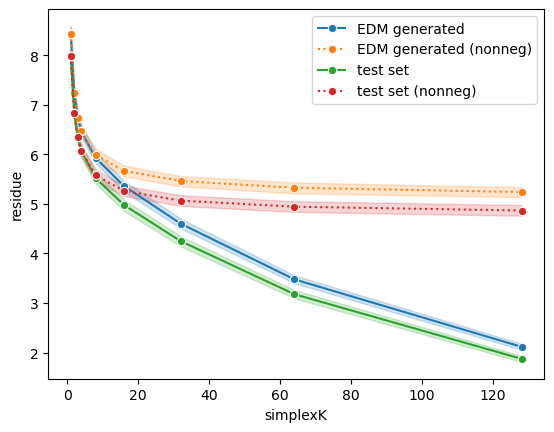

In [149]:
plt.figure()
sns.lineplot(data=result_df, x="simplexK", y="residue", label="EDM generated", marker='o')
sns.lineplot(data=result_df, x="simplexK", y="residue_pos", label="EDM generated (nonneg)", marker='o', linestyle=":")
sns.lineplot(data=result_df2, x="simplexK", y="residue", label="test set", marker='o')
sns.lineplot(data=result_df2, x="simplexK", y="residue_pos", label="test set (nonneg)", marker='o', linestyle=":")
plt.show()

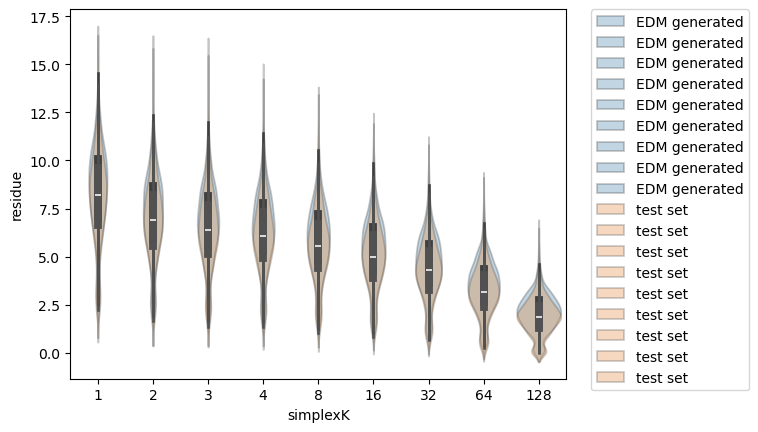

In [163]:
plt.figure()
sns.violinplot(data=result_df, x="simplexK", y="residue", label="EDM generated", alpha=0.3)
sns.violinplot(data=result_df2, x="simplexK", y="residue", label="test set",  alpha=0.3)
# set the legend outside
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

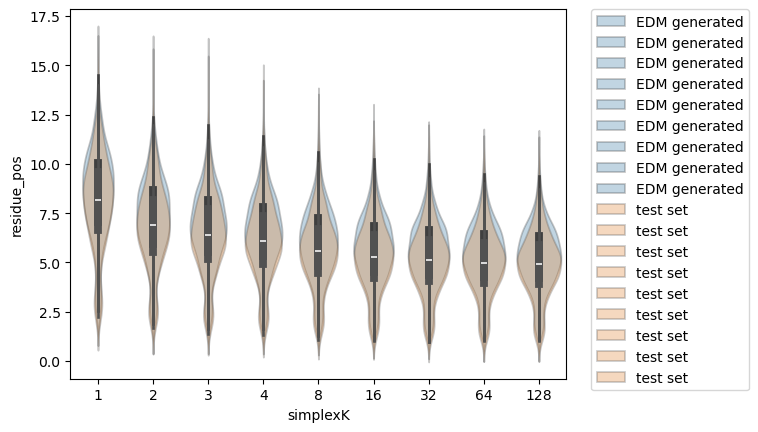

In [162]:
plt.figure()
sns.violinplot(data=result_df, x="simplexK", y="residue_pos", label="EDM generated", alpha=0.3)
sns.violinplot(data=result_df2, x="simplexK", y="residue_pos", label="test set",  alpha=0.3)
# set the legend outside
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

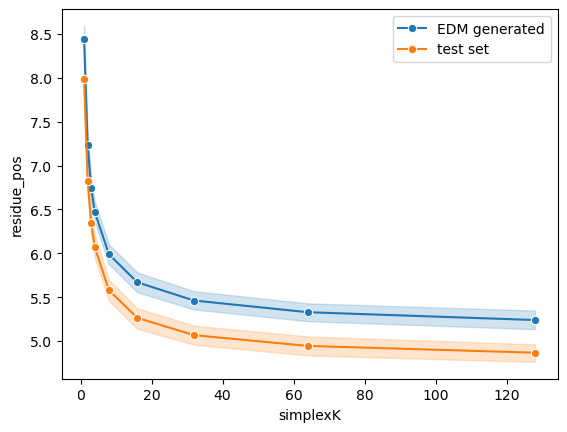

In [143]:
plt.figure()
sns.lineplot(data=result_df, x="simplexK", y="residue_pos", label="EDM generated", marker='o')
sns.lineplot(data=result_df2, x="simplexK", y="residue_pos", label="test set", marker='o')
plt.show()

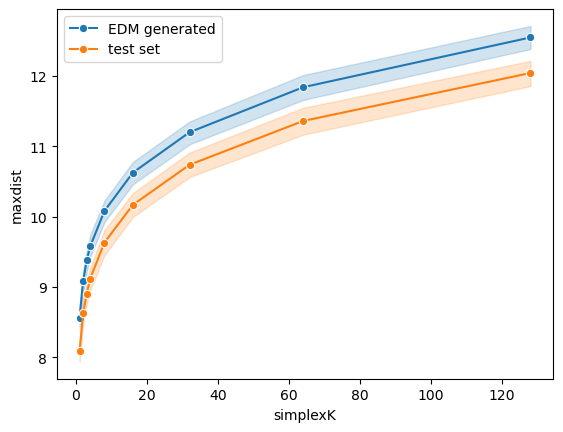

In [144]:
plt.figure()
# add markers='o' to the lineplot to show the data points
sns.lineplot(data=result_df, x="simplexK", y="maxdist", label="EDM generated", marker='o')
sns.lineplot(data=result_df2, x="simplexK", y="maxdist", label="test set", marker='o')
plt.show()

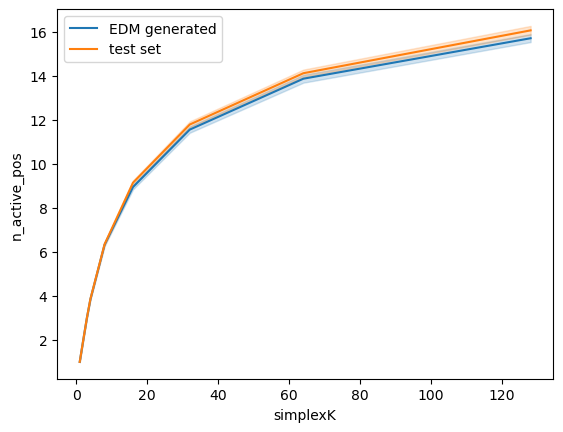

In [138]:
plt.figure()
sns.lineplot(data=result_df, x="simplexK", y="n_active_pos", label="EDM generated")
sns.lineplot(data=result_df2, x="simplexK", y="n_active_pos", label="test set",)
plt.show()

### Scratch zone

In [56]:
simplexK = 4
query = edm_Xmat_test[0:1]
# find top k nearest neighbors in trainingset 
topKdist, topKidxs = torch.cdist(query, edm_Xmat).topk(simplexK, largest=False)
# get the simplex
simplex = edm_Xmat[topKidxs[0]]
# find the coefficients of the query in the simplex
A = np.append(simplex.T.cpu(), np.ones((1, simplexK)), axis=0)
b = np.append(query.T.cpu(), [1])
coefficients, rnorm = nnls(A, b)
recon = np.dot(simplex.T.cpu(), coefficients)
recon = torch.from_numpy(recon)
# find the simplex that contains the query
# find the coefficients of the query in the simplex
# find the nearest neighbors of the simplex
# find the coefficients of the query in the nearest neighbors

In [58]:
(recon - query.cpu()).norm()

tensor(3.6477, dtype=torch.float64)

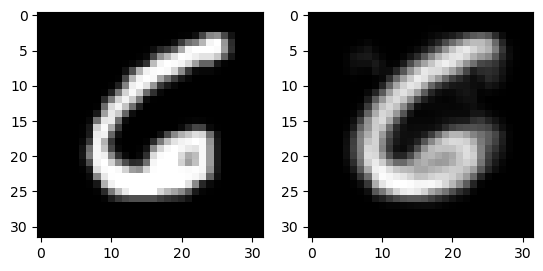

In [153]:
plt.subplot(1, 2, 1)
plt.imshow(query.view(edm_imgshape).cpu().numpy().squeeze(), cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(recon_pos.reshape(edm_imgshape).squeeze(), cmap="gray")
plt.show()

In [39]:
simplex

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]], device='cuda:0')

In [31]:
X @ coefficients

array([0.25, 0.25, 0.  ])

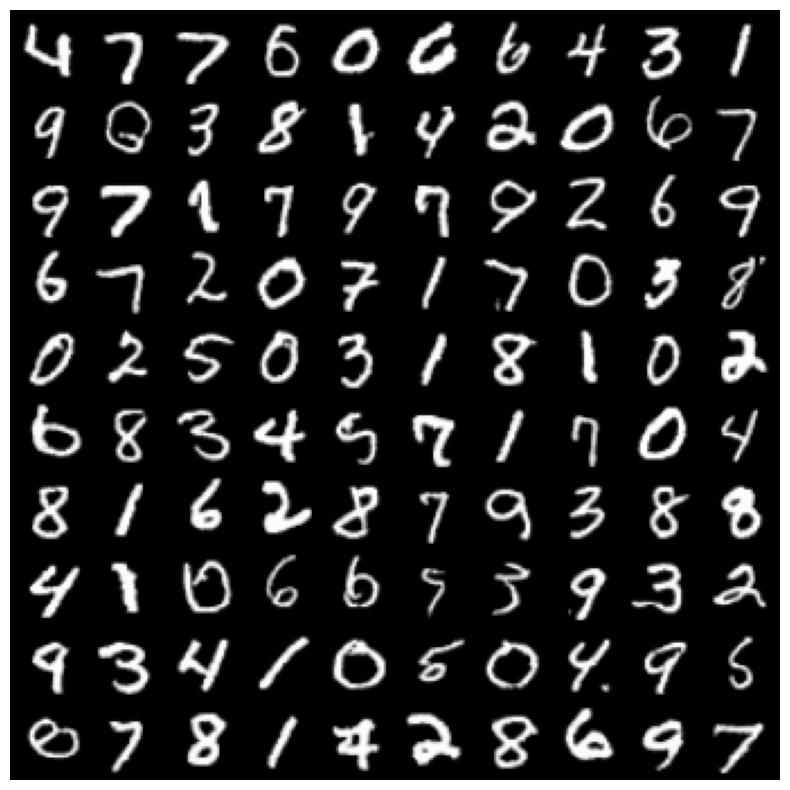

In [13]:
seed = 42
total_steps = 18
fid_batch_size = 100
with torch.no_grad():
    noise = torch.randn([fid_batch_size, config.channels, config.img_size, config.img_size],
                        generator=torch.cuda.manual_seed(seed), device=config.device)
    samples = edm_sampler(edm, noise, num_steps=total_steps, use_ema=False).detach().cpu()
    samples.mul_(0.5).add_(0.5)
    samples = torch.clamp(samples, 0., 1.).cpu()

plt.figure(figsize=(10, 10))
plt.imshow((make_grid(samples*255.0, nrow=10).permute(1, 2, 0)).numpy().astype(np.uint8))
plt.axis('off')
plt.show()


## CIFAR10

In [154]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms

transform = transforms.Compose([transforms.Resize((32, 32)),
                                transforms.ToTensor(), 
                                transforms.Normalize((0.5,), (0.5,))])
# Load the MNIST dataset
train_dataset = datasets.CIFAR10(root='~/Datasets', train=True, download=False, transform=transform)
test_dataset = datasets.CIFAR10(root='~/Datasets', train=False, download=False, transform=transform)
device = "cuda"

Xtsr = torch.stack([x for x, y in train_dataset])
ytsr = torch.tensor(train_dataset.targets)
Xtsr = Xtsr.float()
edm_Xtsr = Xtsr
edm_Xmat = edm_Xtsr.view(edm_Xtsr.shape[0], -1).to(device)
edm_Xmean = edm_Xmat.mean(dim=0)
edm_Xcov = torch.cov(edm_Xmat.T, )
edm_imgshape = tuple(edm_Xtsr.shape[1:])
edm_std_mean = (torch.trace(edm_Xcov) / edm_Xcov.shape[0]).sqrt()
print(edm_imgshape)

Xtsr_test = torch.stack([x for x, y in test_dataset])
edm_Xtsr_test = Xtsr_test
edm_Xmat_test = edm_Xtsr_test.view(edm_Xtsr_test.shape[0], -1).to(device)


(3, 32, 32)


In [166]:
edm_Xmat.min()

tensor(-1., device='cuda:0')

In [ ]:
import sys
sys.path.append("/n/home12/binxuwang/Github/mini_edm")
sys.path.append("/n/home12/binxuwang/Github/DiffusionMemorization")
from train_edm import edm_sampler, EDM, create_model
from core.edm_utils import get_default_config, create_edm

In [ ]:
from core.analytical_score_lib import mean_isotropic_score, Gaussian_score, delta_GMM_score
from core.analytical_score_lib import explained_var_vec
from core.analytical_score_lib import sample_Xt_batch, sample_Xt_batch
from core.gaussian_mixture_lib import gaussian_mixture_score_batch_sigma_torch, \
    gaussian_mixture_lowrank_score_batch_sigma_torch, compute_cluster

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from torchvision.utils import make_grid

In [164]:
ckptdir = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/mini_edm/exps/base_cifar10_20240130-2318/checkpoints"
epoch = 365000 # 49999
config = get_default_config("cifar10")
edm, _ = create_edm(join(ckptdir, f"ema_{epoch}.pth"), config,)

In [167]:
samples_gen = []
for seed in range(40):
    total_steps = 18
    fid_batch_size = 256
    with torch.no_grad():
        noise = torch.randn([fid_batch_size, config.channels, config.img_size, config.img_size],
                            generator=torch.cuda.manual_seed(seed), device=config.device)
        samples = edm_sampler(edm, noise, num_steps=total_steps, use_ema=False).detach().cpu()
        samples.mul_(0.5).add_(0.5)
        samples = torch.clamp(samples, 0., 1.).cpu()
    samples_gen.append(samples)
samples_gen = torch.cat(samples_gen, dim=0)

In [168]:
samples_gen.shape

torch.Size([10240, 3, 32, 32])

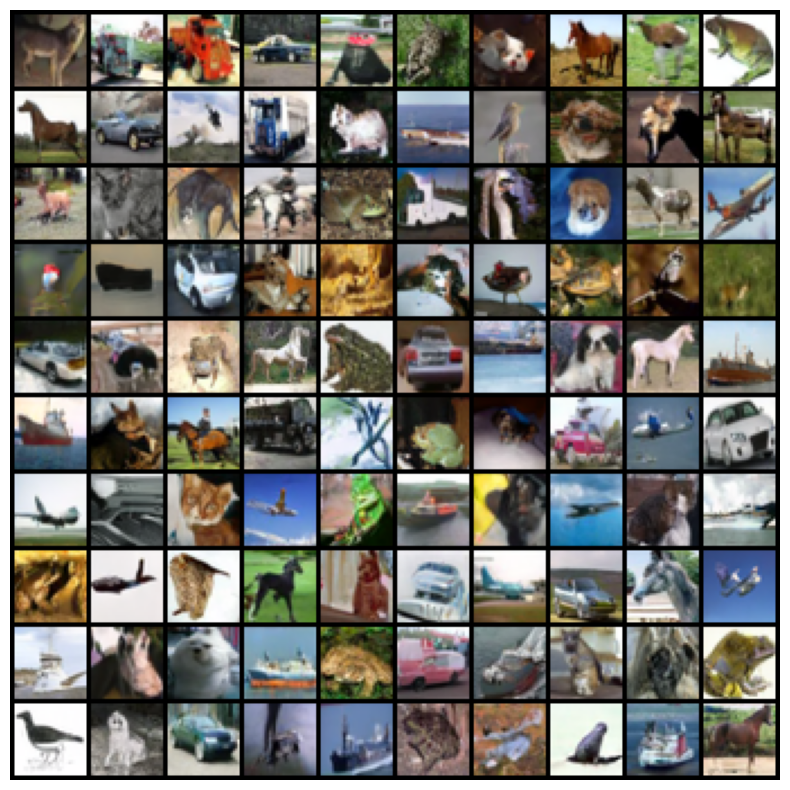

In [170]:
plt.figure(figsize=(10, 10))
plt.imshow((make_grid(samples_gen[:100]*255.0, nrow=10).permute(1, 2, 0)).numpy().astype(np.uint8))
plt.axis('off')
plt.show()

In [181]:
from tqdm import trange
result_col = []

def simplex_regression(query, edm_Xmat, simplexK, weight_alpha=1):
    # find top k nearest neighbors in trainingset 
    topKdist, topKidxs = torch.cdist(query, edm_Xmat).topk(simplexK, largest=False)
    # get the simplex
    simplex = edm_Xmat[topKidxs[0]]
    # find the coefficients of the query in the simplex
    A = np.append(simplex.T.cpu(), weight_alpha * np.ones((1, simplexK)), axis=0)
    b = np.append(query.T.cpu(), [weight_alpha])
    lr = LinearRegression(fit_intercept=False, positive=False).fit(A, b)
    poslr = LinearRegression(fit_intercept=False, positive=True).fit(A, b)
    recon = simplex.T.cpu() @ lr.coef_ 
    residue = (recon - query.cpu()).norm()
    coefsum = lr.coef_.sum()
    coef_sparsity = (lr.coef_ < 1e-3).sum()
    recon_pos = simplex.T.cpu() @ poslr.coef_
    residue_pos = (recon_pos - query.cpu()).norm()
    coefsum_pos = poslr.coef_.sum()
    coef_sparsity_pos = (poslr.coef_ < 1e-3).sum()
    return {"residue": residue.item(), "residue_pos": residue_pos.item(), 
            "coefsum": coefsum, "coefsum_pos": coefsum_pos,
            "coef_sparsity": coef_sparsity, "coef_sparsity_pos": coef_sparsity_pos,
            "maxdist" : topKdist.max().item(), "mindist" : topKdist.min().item()}


def sweep_simplex_regression(querys, edm_Xmat, simplexKs, weight_alpha=1):
    result_col = []
    for test_id  in trange(len(querys)):
        for simplexK in simplexKs:
            query = querys[test_id:test_id+1].float()
            result_dict = simplex_regression(query, edm_Xmat, simplexK, weight_alpha=weight_alpha)
            result_dict["pnt_id"] = test_id
            result_dict["simplexK"] = simplexK
            result_col.append(result_dict)
    return pd.DataFrame(result_col)
    

result_df_cifar_test = sweep_simplex_regression(edm_Xmat_test[:1024], edm_Xmat, 
                                                [1, 2, 3, 4, 8, 16, 32, 64, 128,], weight_alpha=10)

100%|██████████| 1024/1024 [02:57<00:00,  5.77it/s]


In [182]:
samples_gen_mat = samples_gen.view(samples_gen.shape[0], -1).to(device)
samples_gen_mat = (samples_gen_mat - 0.5) / 0.5
result_df_cifar_gen = sweep_simplex_regression(samples_gen_mat[:1024], edm_Xmat, 
                            [1, 2, 3, 4, 8, 16, 32, 64, 128,], weight_alpha=10)

100%|██████████| 1024/1024 [02:58<00:00,  5.74it/s]


In [186]:
result_df_cifar_test.to_csv(f"CIFAR10_simplex_regression_testset.csv", index=False)
result_df_cifar_gen.to_csv(f"CIFAR10_simplex_regression_EDM_uncond_gen_{epoch}.csv", index=False)

In [183]:
result_df_cifar_gen.groupby("simplexK").agg({"residue": "mean", "residue_pos": "mean",
                                    "coefsum": "mean", "coefsum_pos": "mean",
                                    "coef_sparsity": "mean", "coef_sparsity_pos": "mean",
                                    "maxdist": "mean", "mindist": "mean"})

,residue,residue_pos,coefsum,coefsum_pos,coef_sparsity,coef_sparsity_pos,maxdist,mindist
simplexK,,,,,,,,
1,18.787991,18.787991,0.912784,0.912784,0.000000,0.000000,19.133550,19.13355
2,17.342965,17.342965,1.024561,1.024561,0.000000,0.000000,19.642456,19.13355
3,16.676595,16.676660,1.070573,1.070616,0.002930,0.002930,19.925859,19.13355
4,16.292615,16.293449,1.096081,1.096371,0.056641,0.056641,20.125506,19.13355
8,15.491239,15.533240,1.134614,1.142408,1.203125,1.352539,20.612282,19.13355
16,14.617097,14.895700,1.145163,1.179249,4.568359,6.366211,21.131933,19.13355
32,13.459606,14.335600,1.123060,1.208259,11.864258,19.200195,21.685391,19.13355
64,11.893589,13.838318,1.073578,1.233471,26.942383,47.715820,22.302649,19.13355
128,9.936246,13.368855,1.032177,1.256644,57.823242,107.913086,22.992932,19.13355


In [184]:
result_df_cifar_test.groupby("simplexK").agg({"residue": "mean", "residue_pos": "mean",
                                    "coefsum": "mean", "coefsum_pos": "mean",
                                    "coef_sparsity": "mean", "coef_sparsity_pos": "mean",
                                    "maxdist": "mean", "mindist": "mean"})

,residue,residue_pos,coefsum,coefsum_pos,coef_sparsity,coef_sparsity_pos,maxdist,mindist
simplexK,,,,,,,,
1,17.909281,17.909281,0.906581,0.906581,0.000000,0.000000,18.303201,18.303201
2,16.570368,16.570925,1.012721,1.012746,0.001953,0.001953,19.088029,18.303201
3,15.954660,15.955645,1.056819,1.057015,0.018555,0.018555,19.411898,18.303201
4,15.594513,15.598207,1.081546,1.082370,0.097656,0.098633,19.622908,18.303201
8,14.835408,14.885578,1.118382,1.126981,1.212891,1.390625,20.110832,18.303201
16,14.044269,14.313838,1.126067,1.159215,4.604492,6.433594,20.611964,18.303201
32,12.958463,13.787622,1.100533,1.186111,12.041992,19.523438,21.154338,18.303201
64,11.480129,13.311653,1.059936,1.211167,27.082031,48.106445,21.753696,18.303201
128,9.643982,12.869370,1.025252,1.232124,58.108398,108.587891,22.434831,18.303201


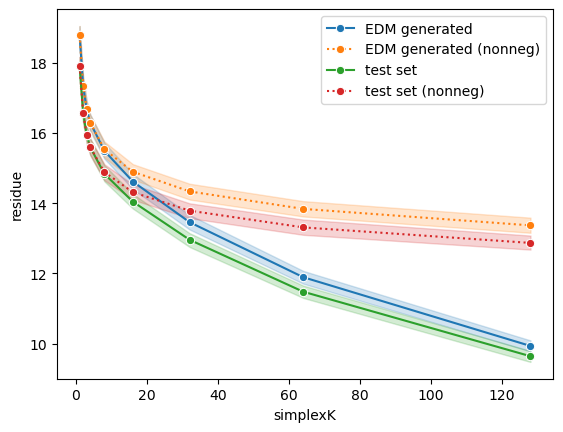

In [185]:
plt.figure()
sns.lineplot(data=result_df_cifar_gen, x="simplexK", y="residue", label="EDM generated", marker='o')
sns.lineplot(data=result_df_cifar_gen, x="simplexK", y="residue_pos", label="EDM generated (nonneg)", marker='o', linestyle=":")
sns.lineplot(data=result_df_cifar_test, x="simplexK", y="residue", label="test set", marker='o')
sns.lineplot(data=result_df_cifar_test, x="simplexK", y="residue_pos", label="test set (nonneg)", marker='o', linestyle=":")
plt.show()